In [1]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn

plt.style.use("ggplot")

In [2]:
# Connect to db
eng = nivapy.da.connect()

Username:  ···
Password:  ········


Connection successful.


# Compare Hg methods

## 1. User options

In [3]:
# Year of interest
year = 2019

# The OSPAR method reduces LOD concs based on the proportion of LODs in the dataset
# Choose whether to apply this scaling to the 'old' data
reduce_lod = True


# The 'old' method is sampled 4 times per year; the 'new' method is monthly
# Choose whether to use only 'new' samples for months where 'old' data are available
# Setting to True should give a fairier comparison of the methods
subset_new = True

## 2. Read station data

In [4]:
xl_path = r"../../../Data/RID_Sites_List_2017-2020.xlsx"
stn_df = pd.read_excel(xl_path, sheet_name="RID_20")

# No data for TROEMÅL
stn_df = stn_df.query("station_code != 'TROEMÅL'")

stn_df.head()

,station_id,station_code,station_name,old_rid_group,new_rid_group,ospar_region,station_type,nve_vassdrag_nr,lat,lon,utm_north,utm_east,utm_zone
0,30019,AAGEVEG,Vegårdselva,rid_108,rid_20,SKAGERAK,R,018.A322,58.669996,8.980983,6503307.0,498897.0,32
1,29612,BUSEDRA,Drammenselva,rid_11,rid_20,SKAGERAK,R,012.A3,59.753995,10.008990,6624446.0,556695.0,32
2,29779,FINEALT,Altaelva,rid_11,rid_20,LOFOTEN-BARENTS SEA,R,212.A0,69.900992,23.286977,7759686.0,586586.0,34
3,29819,FINEPAS,Pasvikelva,rid_36,rid_20,LOFOTEN-BARENTS SEA,R,246.A5,69.500996,30.115996,7712884.0,387322.0,36
4,29820,FINETAN,Tanaelva,rid_36,rid_20,LOFOTEN-BARENTS SEA,R,234.B41,70.229993,28.173988,7791949.0,544316.0,35


## 3. Extract flow data from RESA2

In [5]:
q_dict = {}
for idx, row in stn_df.iterrows():
    stn_id = row["station_id"]
    q_df = nivapy.da.extract_resa_discharge(
        stn_id, f"{year}-01-01", f"{year}-12-31", eng
    )
    q_dict[row["station_code"]] = q_df

## 4. Extract data for "old" Hg method from RESA2

In [6]:
# Identify par ID
par_df = nivapy.da.select_resa_station_parameters(
    stn_df, f"{year}-01-01", f"{year}-12-31", eng
)
par_df.query("parameter_name == 'Hg'")

31 parameters available for the selected stations and dates.


,parameter_id,parameter_name,unit
9,226,Hg,ng/l


In [7]:
# Get chem data
hg_old_df, dup_df = nivapy.da.select_resa_water_chemistry(
    stn_df, [226], f"{year}-01-01", f"{year}-12-31", eng, drop_dups=True, lod_flags=True
)

hg_old_df.head()

,station_id,station_code,station_name,sample_date,depth1,depth2,Hg_ng/l
,,,,,,,
0,29612,BUSEDRA,Drammenselva,2019-02-04 12:00:00,0,0,5
1,29612,BUSEDRA,Drammenselva,2019-05-06 10:30:00,0,0,<1
2,29612,BUSEDRA,Drammenselva,2019-08-05 11:00:00,0,0,<1
3,29612,BUSEDRA,Drammenselva,2019-10-07 12:20:00,0,0,5
4,29613,TELESKI,Skienselva,2019-02-05 10:00:00,0,0,<1


## 5. Read data for "new" Hg method

In [8]:
xl_path = r"../../../Data/hg_niva_method/2019_data/rid_hg_2019_niva_method_tidy.xlsx"
hg_new_df = pd.read_excel(xl_path, sheet_name="tidy")

hg_new_df = hg_new_df.melt(
    id_vars=["station_id", "station_code", "station_name"],
    var_name="month",
    value_name="Hg_ng/l",
)

# Assume each sample collected on the 15th of the month
hg_new_df["month"] = hg_new_df["month"].str.split("_", expand=True)[1].astype(int)
hg_new_df["year"] = year
hg_new_df["day"] = 15
hg_new_df["sample_date"] = pd.to_datetime(hg_new_df[["year", "month", "day"]])
hg_new_df.drop(["year", "month", "day"], inplace=True, axis="columns")

hg_new_df.head()

,station_id,station_code,station_name,Hg_ng/l,sample_date
0,30019,AAGEVEG,Vegårdselva,1.668022,2019-01-15
1,29612,BUSEDRA,Drammenselva,0.690970,2019-01-15
2,29779,FINEALT,Altaelva,0.417513,2019-01-15
3,29819,FINEPAS,Pasvikelva,0.348410,2019-01-15
4,29820,FINETAN,Tanaelva,0.446689,2019-01-15
...,...,...,...,...,...
235,29613,TELESKI,Skienselva,1.338287,2019-12-15
236,38005,TROEMÅL2,Målselva v/gml E6-brua,0.466228,2019-12-15
237,29614,VAGEOTR,Otra,1.908797,2019-12-15
238,29615,VESENUM,Numedalslågen,2.885206,2019-12-15


## 6. Estimate fluxes

In [9]:
data_dict = {"station_code": [], "old_hg_kg": [], "new_hg_kg": []}

for idx, row in stn_df.iterrows():
    stn_code = row["station_code"]

    # Data from old method
    old_df = hg_old_df.query("station_code == @stn_code").copy()
    old_df.set_index("sample_date", inplace=True)
    old_df.drop(
        ["station_id", "station_code", "station_name", "depth1", "depth2"],
        inplace=True,
        axis="columns",
    )
    old_df.sort_index(inplace=True)

    # Split LOD flags
    old_df["Hg_flag"] = old_df["Hg_ng/l"].str.contains("<")
    old_df["Hg_flag"].replace(True, "<", inplace=True)
    old_df["Hg_flag"].replace(False, np.nan, inplace=True)
    old_df["Hg_ng/l"] = old_df["Hg_ng/l"].str.replace("<", "").astype(float)

    if reduce_lod:
        old_df = nivapy.stats.adjust_lod_values(old_df)
    else:
        del old_df["Hg_flag"]

    # Data from new method
    new_df = hg_new_df.query("station_code == @stn_code").copy()
    new_df.set_index("sample_date", inplace=True)
    new_df.drop(
        ["station_id", "station_code", "station_name"],
        inplace=True,
        axis="columns",
    )
    new_df.sort_index(inplace=True)

    if subset_new:
        # Subset 'new' to matching mon ths in 'old'
        old_df["month"] = old_df.index.month
        new_df["month"] = new_df.index.month
        old_months = list(old_df["month"].unique())
        new_df = new_df.query("month in @old_months")
        del old_df["month"], new_df["month"]

    # Flow data
    q_df = q_dict[stn_code]
    q_df.sort_index(inplace=True)

    # Estimate fluxes
    old = nivapy.stats.estimate_fluxes(
        q_df,
        old_df,
        base_freq="D",
        agg_freq="A",
        method="ospar_annual",
    )

    new = nivapy.stats.estimate_fluxes(
        q_df,
        new_df,
        base_freq="D",
        agg_freq="A",
        method="ospar_annual",
    )

    # Build output
    data_dict["station_code"].append(stn_code)
    data_dict["old_hg_kg"].append(old.loc[2019, "Hg_kg"])
    data_dict["new_hg_kg"].append(new.loc[2019, "Hg_kg"])

flux_df = pd.DataFrame(data_dict)
flux_df

,station_code,old_hg_kg,new_hg_kg
0,AAGEVEG,0.786121,1.075168
1,BUSEDRA,31.961658,10.692025
2,FINEALT,1.541605,2.466865
3,FINEPAS,4.997008,13.472983
4,FINETAN,0.000000,12.688839
5,HOREVOS,3.850274,2.005307
6,MROEDRI,4.539914,1.250108
7,NOREVEF,3.931520,2.611341
8,OSLEALN,0.082148,0.145587
9,ROGEBJE,0.000000,1.283810


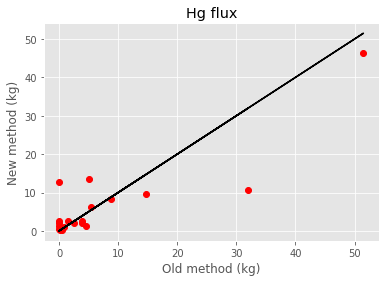

In [10]:
# Scatter plot
plt.plot(flux_df["old_hg_kg"], flux_df["new_hg_kg"], "ro")
plt.plot(flux_df["old_hg_kg"], flux_df["old_hg_kg"], "k-")
plt.xlabel("Old method (kg)")
plt.ylabel("New method (kg)")
_ = plt.title("Hg flux")

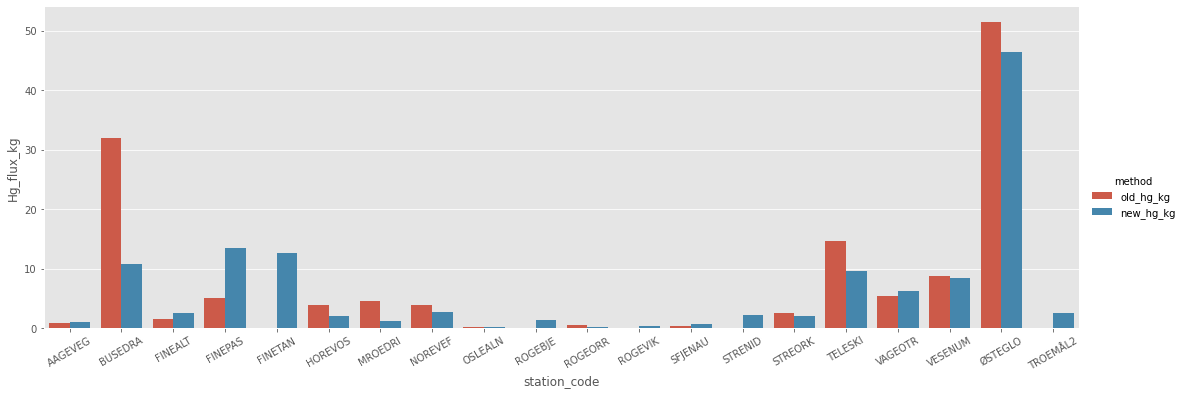

In [11]:
# Bar plot
flux_df2 = flux_df.melt(
    id_vars="station_code", var_name="method", value_name="Hg_flux_kg"
)
g = sn.catplot(
    x="station_code", y="Hg_flux_kg", hue="method", data=flux_df2, kind="bar", aspect=3
)
g.set_xticklabels(rotation=30)

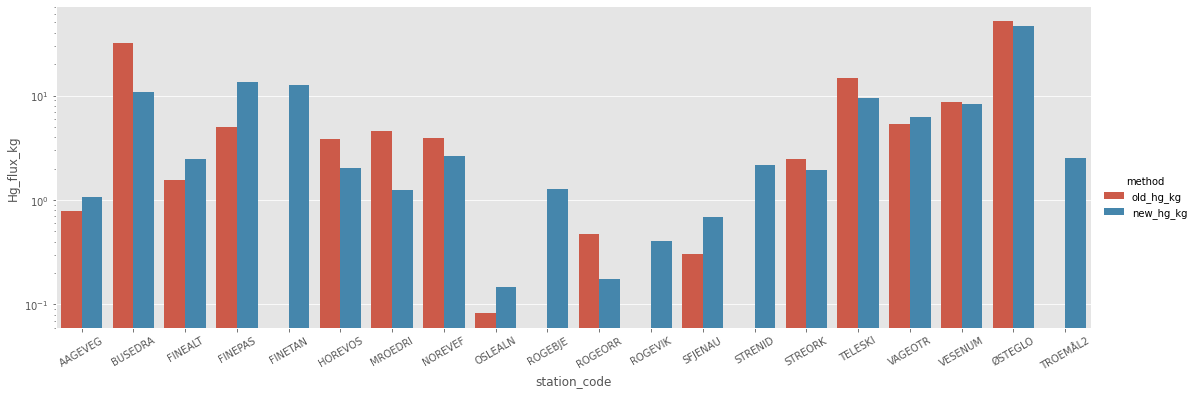

In [12]:
# With logged y-scale
flux_df2 = flux_df.melt(
    id_vars="station_code", var_name="method", value_name="Hg_flux_kg"
)
g = sn.catplot(
    x="station_code", y="Hg_flux_kg", hue="method", data=flux_df2, kind="bar", aspect=3
)
g.set_xticklabels(rotation=30)
g.fig.get_axes()[0].set_yscale("log")